# TV-Inpainting via Preconditioned Douglas-Rachford Iteration

This work is an implementation of the *Preconditioned Douglas-Rachford Splitting
Algorithms for Convex-Concave Saddle-Point Problems* found in this [paper](https://imsc.uni-graz.at/mobis/publications/SFB-Report-2014-002_2.pdf). Here we implemented it for an Image Inpainting Problem.

In [1]:
import numpy as np
import PIL

In [2]:
import os

In [3]:
os.getcwd()

'/content'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving u0.png to u0 (4).png
Saving lossregion.png to lossregion (3).png


In [5]:
from PIL import Image
image = Image.open('u0.png')
imagedata = np.array(image)

### Plot the damaged image

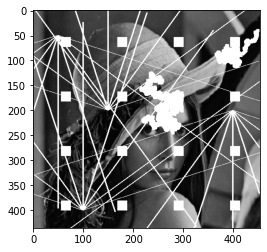

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(imagedata)

### Plot the loss region

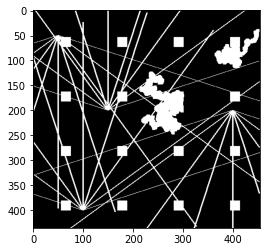

In [7]:
lossimg= Image.open("lossregion.png")
lossdata = np.array(lossimg)
plt.imshow(lossdata)

In [8]:
xdim = imagedata.shape[0]
ydim = imagedata.shape[1]
newimagedata = np.zeros((xdim, ydim), dtype= np.float64)
newlossdata  = np.zeros((xdim, ydim), dtype= np.float64)
for i  in range(0, xdim):
    for j in range(0, ydim):
        newimagedata[i][j] = imagedata[i][j][0]
        newlossdata[i][j] = lossdata[i][j][0]

In [9]:
omega_prime = [(i,j) for i  in range(0, xdim) for j in range(0, ydim) if newlossdata[i][j] == 0]
omega_prime_prime = [(i,j) for i  in range(0, xdim) for j in range(0, ydim) if newlossdata[i][j] != 0]

In [10]:
def gradient(img):

    '''
    Compute the gradient of an matrix as a numpy array
    
    '''
    shape = [img.ndim, ] + list(img.shape)
    gradient = np.zeros(shape, dtype=img.dtype)
    slice_all = [0, slice(None, -1),]


    for d in range(img.ndim):
        gradient[tuple(slice_all)] = np.diff(img, axis=d)
        slice_all[0] = d + 1
        slice_all.insert(1, slice(None))


    return gradient

In [11]:
def divergence(grad):
    '''
    Compute the divergence of a gradient of a matrix
    
    '''
    res = np.zeros(grad.shape[1:])

    for d in range(grad.shape[0]):
        my_grad = np.rollaxis(grad[d], d)
        my_res = np.rollaxis(res, d)
        my_res[:-1] += my_grad[:-1]
        my_res[1:-1] -= my_grad[:-2]
        my_res[-1] -= my_grad[-2]

    return res

In [12]:
omega = omega = [ (i,j) for i in range(0, xdim) for j in range(0, ydim)]
first = [(0, j) for j in range(1, ydim-1)]
second = [(xdim-1, j) for j in range(1, ydim-1)]
third = [(i, 0)  for i in range(1, xdim -1 )]
fourth = [(i, ydim -1)  for i in range(1, xdim -1 )]
edges = first + second + third + fourth
corners = [(0,0), (0, ydim-1), (xdim-1, 0), (xdim-1, ydim-1)]
interiors = [(i,j) for i in range(1, xdim -1) for j in range(1, ydim-1)]


neigbours = dict()
for i , j in omega:
    neigbours[(i,j)] = []
    itspossiblerange = [(p,q) for p in range(i-1,i+3) for q in range(j-1,j+3)]
    for p, q in itspossiblerange:
        if abs(i-p) + abs(j-q) == 1:
            neigbours[(i,j)].append((p,q))

In [13]:
def sum_neig(i, j, s):
    list_of_neigh = neigbours[(i,j)]
    sum = 0
    for i, j in list_of_neigh:
        try:
            sum = sum + s[i][j]
        except:
             sum = sum 
    return sum 

In [14]:
alpha = 1.0

def proximalF(p, tau = 1.0):

    output =  np.sign(p) * np.maximum(np.abs(p) - alpha*tau, 0)  

    return output
    
def proximalFstar(p, tau = 1.0):

    #p = np.clip(p, -alpha/tau, alpha/tau)

    norm = np.maximum(np.sqrt(np.sum(p**2, 0))/(alpha/tau), 1)
   
    output = np.copy(p)
   
    output[0] /= norm
   
    output[1] /= norm
   
    return output


def proximalG(u, sigma):

    for i, j in omega:
        
        if newlossdata[i][j] == 255:
            
            u[i][j] = u[i][j]
            
        else:
            
            u[i][j] = newimagedata[i][j]

    return u

In [15]:
def sym_red_black_gauss_seidel(u, lamda, mu, b, n):
    
    u_big = u
    v_big =  np.zeros((xdim, ydim), dtype= np.float64)
  
    
    for v in range(0, n):
       
        #Update all red points 

        for i, j in edges:
            if (i+j) % 2 == 0: v_big[i][j] = (1 / (lamda + (3*mu))) *  (b[i][j] + (lamda * sum_neig(i, j, u_big )))
            
        for i, j in corners:
            if (i+j) % 2 == 0: v_big[i][j] = (1 / (lamda + (2*mu))) * (b[i][j] + (lamda * sum_neig(i, j, u_big)))

        for i, j in interiors:
            if (i+j) % 2 == 0: v_big[i][j] = (1 / (lamda + (4*mu))) * (b[i][j] + (lamda * sum_neig(i, j, u_big)))

          
         #Update all black points 

        for i, j in edges:
            if (i+j) % 2 != 0: v_big[i][j] = (1 / (lamda + (3*mu))) *  (b[i][j] + (lamda * sum_neig(i, j, v_big )))
            
        for i, j in corners:
            if (i+j) % 2 != 0: v_big[i][j] = (1 / (lamda + (2*mu))) * (b[i][j] + (lamda * sum_neig(i, j, v_big)))

        for i, j in interiors:
            if (i+j) % 2 != 0: v_big[i][j] = (1 / (lamda + (4*mu))) * (b[i][j] + (lamda * sum_neig(i, j, v_big)))
        
        u_big = v_big

    return v_big

## Preconditioned Douglas-Rachford Iteration

In [16]:
def tv_inpainting(num_of_iter, n_for_gauss, sigma, tau , u_0, p_0, u_bar_0, p_bar_0):

    lamda =  1
    mu = pow((sigma*tau), 2)
    u = u_0
    p = p_0
    u_bar = u_bar_0
    p_bar = p_bar_0
    k = 0


    while k < num_of_iter:
      
        b = u_bar + (sigma * tau * divergence(p_bar))
            
        u =  sym_red_black_gauss_seidel(u, lamda, mu, b , n_for_gauss)         
            
        p  = p_bar + (sigma * tau * gradient(u))
        
        u_test =  proximalG((2*u) - u_bar, sigma)
                                                                                                    
        u_bar = u_bar + u_test - u
        
        p_test = proximalFstar((2*p)-p_bar, tau)
        
        p_bar = p_bar + p_test - p

        k = k + 1
      
    return u, p , u_bar , p_bar

In [17]:
sigma = 14
tau =  1/sigma
num_of_iter = 200
n_for_gauss  = 3
u_0 =  newimagedata
u_bar_0 =  u_0
p_0 =   np.zeros((2, xdim, ydim), dtype = np.float64)
p_bar_0 =  p_0
u, p, u_bar, p_bar = tv_inpainting(num_of_iter, n_for_gauss, sigma, tau, u_0, p_0, u_bar_0, p_bar_0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


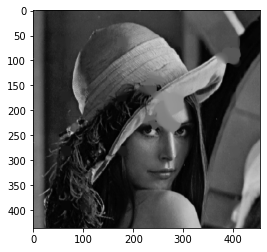

In [18]:
finaldata = np.zeros((xdim, ydim, 3), dtype=np.int)

for i  in range(0, xdim):
  for j in range(0, ydim):
    finaldata[i][j] = np.array([ u[i][j], u[i][j], u[i][j] ])
plt.figure()
plt.imshow(finaldata)

In [19]:
def sym_red_black_gauss_seidel(u, lamda, mu, b, n):
    
    u_big = np.zeros((n+1, xdim, ydim), dtype= np.float64)
    u_big[0] = u       
    
    for v in range(0, n):
       
        #Update all red points

        for i, j in edges:
            if (i+j) % 2 == 0: u_big[v+1][i][j] = (1 / (lamda + (3*mu))) *  (b[i][j] + (lamda * sum_neig(i, j, u_big[v] )))
            
        for i, j in corners:
            if (i+j) % 2 == 0: u_big[v+1][i][j] = (1 / (lamda + (2*mu))) * (b[i][j] + (lamda * sum_neig(i, j, u_big[v])))

        for i, j in interiors:
            if (i+j) % 2 == 0: u_big[v+1][i][j] = (1 / (lamda + (4*mu))) * (b[i][j] + (lamda * sum_neig(i, j, u_big[v])))

          
        #Update all black points

        for i, j in edges:
            if (i+j) % 2 != 0: u_big[v+1][i][j] = (1 / (lamda + (3*mu))) *  (b[i][j] + (lamda * sum_neig(i, j, u_big[v+1] )))
            
        for i, j in corners:
            if (i+j) % 2 != 0: u_big[v+1][i][j] = (1 / (lamda + (2*mu))) * (b[i][j] + (lamda * sum_neig(i, j, u_big[v+1])))

        for i, j in interiors:
            if (i+j) % 2 != 0: u_big[v+1][i][j] = (1 / (lamda + (4*mu))) * (b[i][j] + (lamda * sum_neig(i, j, u_big[v+1])))

    return u_big[n] 

In [20]:
def tv_inpainting(num_of_iter, n_for_gauss, sigma, tau , u_0, p_0, u_bar_0, p_bar_0):

    lamda =  1
    mu = pow((sigma*tau), 2)
    
    u =  np.zeros((num_of_iter+1, xdim, ydim), dtype = np.float64)
    u_bar = np.zeros((num_of_iter+1, xdim, ydim), dtype= np.float64)
    u_test = np.zeros((num_of_iter+1, xdim, ydim), dtype = np.float64)

    p = np.zeros((num_of_iter+1, 2, xdim, ydim ), dtype = np.float64)
    p_bar = np.zeros((num_of_iter+1, 2, xdim, ydim), dtype = np.float64)
    p_test = np.zeros((num_of_iter+1, 2, xdim, ydim), dtype = np.float64)

    b =  np.zeros((num_of_iter+1, xdim, ydim), dtype = np.float64)
    
    u[0] = u_0
    p[0] = p_0
    u_bar[0] = u_bar_0
    p_bar[0] = p_bar_0


    for k in range(0, num_of_iter):
      
        b[k] = u_bar[k] + (sigma * tau * divergence(p_bar[k]))
            
        u[k+1] =  sym_red_black_gauss_seidel(u[k], lamda, mu, b[k] , n_for_gauss)         
            
        p[k+1]  = p_bar[k] + (sigma * tau * gradient(u[k+1]))
        
        u_test[k+1]=  proximalG((2*u[k+1]) - u_bar[k], sigma)
                                                                                                    
        u_bar[k+1] = u_bar[k] + u_test[k+1] - u[k+1]
        
        p_test[k+1] = proximalFstar((2*p[k+1])-p_bar[k], tau)
        
        p_bar[k+1] = p_bar[k] + p_test[k+1] - p[k+1]
      
    return u, p , u_bar , p_bar

In [21]:
sigma = 14
tau =  1/sigma
num_of_iter = 200
n_for_gauss  = 3
u_0 =  newimagedata
u_bar_0 =  u_0
p_0 =   np.zeros((2, xdim, ydim), dtype = np.float64)
p_bar_0 =  p_0
u, p, u_bar, p_bar = tv_inpainting(num_of_iter, n_for_gauss, sigma, tau, u_0, p_0, u_bar_0, p_bar_0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


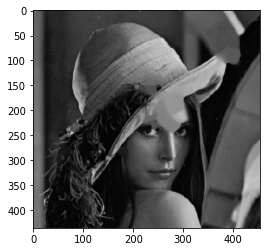

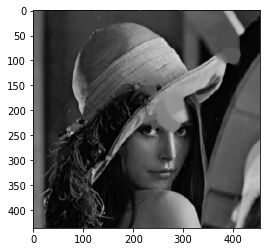

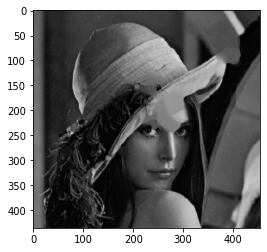

In [22]:
finaldata = np.zeros((xdim, ydim, 3), dtype=np.int)
for image in u[198:]:
    for i  in range(0, xdim):
        for j in range(0, ydim):
            finaldata[i][j] = np.array([ image[i][j], image[i][j], image[i][j] ])
    plt.figure()
    plt.imshow(finaldata)